# Deep Learning

# Loading Data, EDA, Feature Engineering, and Preprocessing

In [57]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import sklearn
TARGET = 'price'
COMPETITION = 'playground-series-s3e6'

def load_data(target = TARGET,load_original=True):
    # Load the data, turn it into tensors
    train_df = pd.read_csv('train.csv', index_col='id')
    test_df = pd.read_csv('test.csv', index_col='id')

    # Add generative flags
    train_df['is_generated'] = 1
    test_df['is_generated'] = 1

    if load_original:
        original = pd.read_csv('ParisHousing.csv')
        original['is_generated'] = 0
        ext_df = original
        train_df = pd.concat([ext_df,train_df])
        train_df = train_df.reset_index(drop=True)


    print("Training Size:", train_df.shape)
    print("Test Size:", test_df.shape)
    
    # Reset index
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    FEATURES = [col for col in train_df.columns if col not in ['id', target]]
    print("Num Features:", len(FEATURES))


    train_tensors = torch.tensor(train_df[FEATURES].values, dtype=torch.float32)
    target_tensors = torch.tensor(train_df[target].values, dtype=torch.float32)
    test_tensors = torch.tensor(test_df[FEATURES].values, dtype=torch.float32)
    output_dict = {
        "train_df": train_df,
        "test_df": test_df,
        "train_tensors": train_tensors,
        "target_tensors": target_tensors,
        "test_tensors": test_tensors,
    }
    return output_dict

load_dict = load_data(load_original=True)

train_df = load_dict['train_df']
test_df = load_dict['test_df']

train_df.shape,test_df.shape

Training Size: (32730, 18)
Test Size: (15154, 17)
Num Features: 17


((32730, 18), (15154, 17))

In [58]:
df_train = load_dict['train_df']
df_test = load_dict['test_df']
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32730 entries, 0 to 32729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       32730 non-null  int64  
 1   numberOfRooms      32730 non-null  int64  
 2   hasYard            32730 non-null  int64  
 3   hasPool            32730 non-null  int64  
 4   floors             32730 non-null  int64  
 5   cityCode           32730 non-null  int64  
 6   cityPartRange      32730 non-null  int64  
 7   numPrevOwners      32730 non-null  int64  
 8   made               32730 non-null  int64  
 9   isNewBuilt         32730 non-null  int64  
 10  hasStormProtector  32730 non-null  int64  
 11  basement           32730 non-null  int64  
 12  attic              32730 non-null  int64  
 13  garage             32730 non-null  int64  
 14  hasStorageRoom     32730 non-null  int64  
 15  hasGuestRoom       32730 non-null  int64  
 16  price              327

In [59]:
df_train.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,is_generated
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,0
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,0
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,0
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,0
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,0


In [60]:
pd.DataFrame(
    [len(df_train), len(df_test), len(df_train)],
    index=['train', 'test', 'original'],
    columns=['count']
)

,count
train,32730
test,15154
original,32730


In [61]:
TARGET = 'price'
pd.concat([
    pd.DataFrame(df_train.drop(columns=[TARGET]).isnull().sum(), columns=['missing train']),
    pd.DataFrame(df_test.isnull().sum(), columns=['missing test']),
], axis=1)

,missing train,missing test
squareMeters,0,0
numberOfRooms,0,0
hasYard,0,0
hasPool,0,0
floors,0,0
cityCode,0,0
cityPartRange,0,0
numPrevOwners,0,0
made,0,0
isNewBuilt,0,0


In [62]:
from scipy import stats
def check_outliers(df, z=3):
    df_z_score = stats.zscore(df)
    columns = df.columns.tolist()
    if TARGET in columns:
        columns.remove(TARGET)
    for c in columns:
        df_outlier = df_z_score.query(f'{c} > 3 | {c} < -3')
        if len(df_outlier):
            display(df.loc[df_outlier.index][[c]])

In [63]:
check_outliers(df_train)


,squareMeters
25334,6071330


,floors
15659,6000


,cityCode
10299,201035
11326,491100
12425,465360
20987,200812
30576,146275
30735,200801
32631,200801


,made
12113,10000
13608,10000
29124,10000
29748,10000
31400,10000


,basement
12107,84333
13995,81851
25068,91992
28926,91978


,attic
13828,71001
14909,71001
22858,71024
23633,96381
23642,30000
27168,71965
29994,30000


,garage
24878,2048
27629,9017


In [64]:
df_z_score = stats.zscore(df_train)
columns_to_remove = ['squareMeters', 'floors', 'made', 'garage']
df_outlier = df_z_score[((df_z_score[columns_to_remove] > 3) | (df_z_score[columns_to_remove] < -3)).max(axis=1)]
df_train = df_train.loc[df_train.index.difference(df_outlier.index)]
df_train.set_index(df_train.reset_index().index, inplace=True)

In [66]:
df_train.shape

(32721, 18)

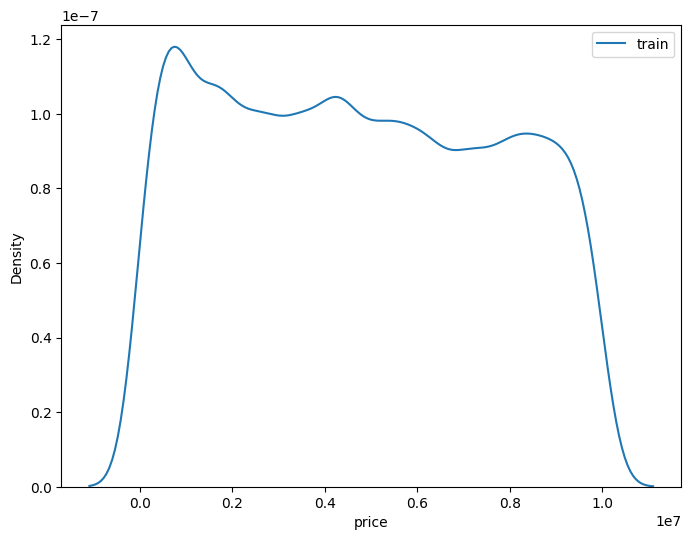

In [68]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.kdeplot(data=df_train, x=TARGET, label='train')
plt.legend()

In [69]:
def add_features(df):
    df['allSpace'] = df['squareMeters'] + df['basement'] + df['attic']
    df['roomsPerFloor'] = df['numberOfRooms'] / df['floors']
    df['age'] = 2022 - df['made']
    df['prevOwnersPerYear'] = df['numPrevOwners'] / df['age']
    city_code_count = df['cityCode'].value_counts()    
    df['numHousesInCityCode'] = df['cityCode'].map(city_code_count)
    city_code_space = df.groupby('cityCode')['squareMeters'].sum()
    df['sumAllSpaceInCityCode'] = df['cityCode'].map(city_code_space)
    return df

df_train = add_features(df_train)
df_test = add_features(df_test)

In [70]:
df_train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,...,hasStorageRoom,hasGuestRoom,price,is_generated,allSpace,roomsPerFloor,age,prevOwnersPerYear,numHousesInCityCode,sumAllSpaceInCityCode
0,75523,3,0,1,63,9373,3,8,2005,0,...,0,7,7559081.5,0,88841,0.047619,17,0.470588,2,80321
1,80771,39,1,1,98,39381,8,6,2015,1,...,1,2,8085989.5,0,86860,0.397959,7,0.857143,5,145004
2,55712,58,0,1,19,34457,6,8,2021,0,...,1,9,5574642.1,0,67501,3.052632,1,8.000000,2,146159
3,32316,47,0,0,6,27939,10,4,2012,0,...,0,3,3232561.2,0,40116,7.833333,10,0.400000,3,73682
4,70429,19,1,1,90,38045,3,7,1990,1,...,1,4,7055052.0,0,81293,0.211111,32,0.218750,2,111945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32716,55825,84,1,0,70,12031,3,10,2000,0,...,0,0,5594137.1,1,61088,1.200000,22,0.454545,9,480827
32717,65870,88,1,0,49,23197,9,9,2015,0,...,0,7,6594705.0,1,73135,1.795918,7,1.285714,6,410699
32718,93192,42,1,0,39,8539,10,5,2014,1,...,0,0,9321511.4,1,102859,1.076923,8,0.625000,5,327980
32719,65797,86,1,0,89,23197,2,10,2000,1,...,0,0,6584708.2,1,73668,0.966292,22,0.454545,6,410699


# Preprocessing

In [113]:
import subprocess
import os

def check_colab():
    """Function to check if we are running on colab. Install packages if we are."""
    try:
        import google.colab
        IN_COLAB = True
        print("Running on Colab")
        results = subprocess.run(["pip", "install", "-r", "requirements.txt"], check=True, capture_output=True)
        # Check if the installation was successful
        if results.returncode == 0:
            print("Installation successful")
            print("You may need to restart the runtime for the changes to take effect")
            from dotenv import load_dotenv
            load_dotenv()
            print("Loaded environment variables from .env file")
            subprocess.call(['chmod', '+x', './submit_kaggle.sh'])    

        else:
            print("Installation failed")
            print(results.stdout)
        
    except:
        IN_COLAB = False
    return IN_COLAB
check_colab();

def check_kaggle():
    """Check if we're running in a Kaggle notebook"""
    if 'KAGGLE_URL_BASE' not in os.environ:
        return 
    try: 
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("KAGGLE_KEY")
        secret_value_1 = user_secrets.get_secret("KAGGLE_USERNAME")
        os.environ['KAGGLE_USERNAME'] = secret_value_1
        os.environ['KAGGLE_KEY'] = secret_value_0
    except:
        pass
    print("Running on kaggle.")    
    return True
running_on_kaggle = check_kaggle()


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import fetch_california_housing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import (
    Dataset,
    DataLoader,
    TensorDataset,
    random_split,
    SubsetRandomSampler,
)
from torchvision import transforms, utils

import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import csv
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap import UMAP
from haversine import haversine

TARGET = 'price'
COMPETITION = 'playground-series-s3e6'

def load_data(target = TARGET,load_original=True):
    # Load the data, turn it into tensors
    train_df = pd.read_csv('train.csv', index_col='id')
    test_df = pd.read_csv('test.csv', index_col='id')

    # Add generative flags

    if load_original:
        test_df['is_generated'] = 1
        train_df['is_generated'] = 1
        original = pd.read_csv('ParisHousing.csv')
        original['is_generated'] = 0
        ext_df = original
        train_df = pd.concat([ext_df,train_df])
        train_df = train_df.reset_index(drop=True)


    
    # Reset index
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    FEATURES = [col for col in train_df.columns if col not in ['id', target]]


    train_tensors = torch.tensor(train_df[FEATURES].values, dtype=torch.float32)
    target_tensors = torch.tensor(train_df[target].values, dtype=torch.float32)
    test_tensors = torch.tensor(test_df[FEATURES].values, dtype=torch.float32)
    output_dict = {
        "train_df": train_df,
        "test_df": test_df,
        "train_tensors": train_tensors,
        "target_tensors": target_tensors,
        "test_tensors": test_tensors,
    }
    return output_dict

def feature_engineering(df):
    df['allSpace'] = df['squareMeters'] + df['basement'] + df['attic']
    df['roomsPerFloor'] = df['numberOfRooms'] / df['floors']
    df['age'] = 2022 - df['made']
    df['prevOwnersPerYear'] = df['numPrevOwners'] / df['age']
    city_code_count = df['cityCode'].value_counts()    
    df['numHousesInCityCode'] = df['cityCode'].map(city_code_count)
    city_code_space = df.groupby('cityCode')['squareMeters'].sum()
    df['sumAllSpaceInCityCode'] = df['cityCode'].map(city_code_space)
    return df

def remove_outliers(df_train,z_score = 3):
    df_z_score = stats.zscore(df_train)
    columns_to_remove = ['squareMeters', 'floors', 'made', 'garage']
    df_outlier = df_z_score[((df_z_score[columns_to_remove] > 3) | (df_z_score[columns_to_remove] < -3)).max(axis=1)]
    df_train = df_train.loc[df_train.index.difference(df_outlier.index)]
    df_train.set_index(df_train.reset_index().index, inplace=True)
    return df_train

def sklearn_standardize(train_df,test_df,target = TARGET):
    # Standardize the data
    print("Standardizing the data.")
    scaler = StandardScaler()
    scaler.fit(train_df.drop(target,axis=1))
    x_df = train_df.drop(target,axis=1)
    x_df = scaler.transform(x_df)
    x_df = pd.DataFrame(x_df,columns=train_df.drop(target,axis=1).columns)
    y_df = train_df[target]
    y_df = pd.DataFrame(y_df,columns=[target])
    x_test_df = test_df.copy()
    x_test_df = scaler.transform(x_test_df)
    x_test_df = pd.DataFrame(x_test_df,columns=test_df.columns)
    return x_df, y_df, x_test_df


def preprocess(train_df,test_df):
    # Preprocess the data
    # Remove outliers
    train_df = remove_outliers(train_df)
    # Feature engineering
    train_df = feature_engineering(train_df)
    test_df = feature_engineering(test_df)
    # Standardize the data
    x_df, y_df, x_test_df = sklearn_standardize(train_df,test_df)
    return x_df, y_df, x_test_df

def main_load(load_original = True):
    # Load the data
    data_dict = load_data(TARGET,load_original)
    train_df = data_dict['train_df']
    test_df = data_dict['test_df']
    train_tensors = data_dict['train_tensors']
    target_tensors = data_dict['target_tensors']
    test_tensors = data_dict['test_tensors']

    # Preprocess the data
    x_df, y_df, x_test_df = preprocess(train_df,test_df)

    # Convert to tensors
    train_tensors = torch.from_numpy(x_df.values).float()
    target_tensors = torch.from_numpy(y_df.values).float().squeeze(1)
    test_tensors = torch.from_numpy(x_test_df.values).float()

    print("Number of features:", train_tensors.shape[1])

    # Create the dataset
    train_dataset = TensorDataset(train_tensors, target_tensors)
    test_dataset = TensorDataset(test_tensors)

    # Create test dataloader
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    return train_dataset, test_dataset, test_loader,x_df

train_dataset,test_dataset,test_loader,x_df = main_load(False)

Standardizing the data.
Number of features: 22


# Model

In [114]:
# Define models
class HousePricesModel(nn.Module):
    def __init__(self,input_dim=22):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    def forward(self, x):
        return self.head(x)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf


    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def KFold_train_model(train_dataset,k_folds):
    k_folds = k_folds
    kfold = KFold(n_splits=k_folds, shuffle=True)

    loss_list = []  
    val_loss_list = []
    models = []


    for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dataset)):
        print(f"Fold {fold}")
        print('--------------------------------')
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = SubsetRandomSampler(train_ids)
        valid_subsampler = SubsetRandomSampler(valid_ids)

        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256,
                                                    sampler=train_subsampler)
        valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256,
                                                    sampler=valid_subsampler)
        
        early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

        model = HousePricesModel()
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)
        # Add reduce lr on plateau
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience = 10, factor = 0.5)

        loss_func = nn.MSELoss()

        for epoch in range(1000):
            # Training
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                xb = xb.float()
                yb = yb.float()
                y_hat = model(xb)
                y_hat = y_hat.squeeze()
                loss = loss_func(y_hat,yb)
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                valid_loss = 0
                for xb, yb in valid_loader:
                    xb = xb.float()
                    yb = yb.float()
                    y_hat = model(xb)
                    y_hat = y_hat.squeeze()
                    loss = loss_func(y_hat, yb)
                    valid_loss += loss.item()

                valid_loss /= len(valid_loader)
                scheduler.step(valid_loss)

            print(f"Epoch: {epoch}\t Validation Loss: {valid_loss}")
            if early_stopper.early_stop(valid_loss):
                print("Early stopping")
                break
        val_loss_list.append(valid_loss)
        models.append(model)
        print('--------------------------------')

    print('Average validation loss: ', np.mean(val_loss_list))
    return models,val_loss_list

def make_ensemble_predictions(models, test_loader):
    """Make ensemble predictions from the best models.
    Average the predictions of the best models.
    """
    predictions = []
    for model in models:
        model_predictions = []
        model.eval()
        with torch.no_grad():
            for xb in test_loader:
                xb = xb[0]
                y_hat = model(xb)
                y_hat = y_hat.squeeze()
                model_predictions.append(y_hat)
        predictions.append(torch.cat(model_predictions))
    predictions = torch.stack(predictions)
    predictions = torch.mean(predictions, dim=0)
    return predictions

def save_predictions(preds, target=TARGET):
    # Save predictions to csv file
    df = pd.read_csv('sample_submission.csv')
    df[target] = preds

    # Make sure we have two columns in df
    assert df.shape[1] == 2, f"Expected df to have 2 columns, but got {df.shape[1]} columns"
    df.to_csv("submission.csv", index=False)
    return

def submit_kaggle():
    kaggle_cli = '/Users/dbless/Library/Python/3.11/bin/kaggle'
    competition = COMPETITION
    submission = "submission.csv"
    message = "Statistics may be dull, but it has its moments."
    result = subprocess.run(['./submit_kaggle.sh',kaggle_cli,competition,submission,message],cwd=os.getcwd(), capture_output=True, text=True)
    print(result.stdout)
    return
models, val_loss_list = KFold_train_model(train_dataset,10)
preds = make_ensemble_predictions(models, test_loader)
save_predictions(preds)
submit_kaggle()

Fold 0
--------------------------------
Epoch: 0	 Validation Loss: 30402046707484.445
Epoch: 1	 Validation Loss: 30384936510350.223
Epoch: 2	 Validation Loss: 30448496294115.555
Epoch: 3	 Validation Loss: 30418665472000.0
Epoch: 4	 Validation Loss: 30378011248412.445
Epoch: 5	 Validation Loss: 30379351095523.555
Epoch: 6	 Validation Loss: 30342360829496.89
Epoch: 7	 Validation Loss: 30376349371960.89
Epoch: 8	 Validation Loss: 30331919575722.668
Epoch: 9	 Validation Loss: 30316221926968.89
Epoch: 10	 Validation Loss: 30332131388074.668
Epoch: 11	 Validation Loss: 30349904518257.777
Epoch: 12	 Validation Loss: 30268213457351.11
Epoch: 13	 Validation Loss: 30258046464455.11
Epoch: 14	 Validation Loss: 30219309969863.11
Epoch: 15	 Validation Loss: 30182005830087.11
Epoch: 16	 Validation Loss: 30178395932444.445
Epoch: 17	 Validation Loss: 30209096140572.445
Epoch: 18	 Validation Loss: 30139189209770.668
Epoch: 19	 Validation Loss: 30086875287096.89
Epoch: 20	 Validation Loss: 300686132874